In [ ]:
# @title Import Libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# @title Upload the training files
# Specify the column names
col_pos_train = ['ID', 'Species', 'Kingdom', 'Length', 'Cleavage', 'Set']
col_neg_train = ['ID', 'Species', 'Kingdom', 'Length', 'Transmembrane', 'Set']

# Load the TSV file into a DataFrame
pos_train = pd.read_csv('pos-train.tsv', sep='\t', header=None, names=col_pos_train)
neg_train = pd.read_csv('neg-train.tsv', sep='\t', header=None, names=col_neg_train)

In [ ]:
# @title Creation of the customized files
#Create a customize file for the positives
with open('positive.fasta', 'r') as read:
  with open('vonHeijne_pos.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = pos_train.query("ID == @line")
        if not query['Cleavage'].empty:
          end = int(query['Cleavage'].iloc[0])
          line = read.readline()
          # The final line will contain: id, sequence of the region arounf the cleavage site, set number, class (1 for positive), the first 90 characters
          print(query['ID'].iloc[0]+'\t'+line[end-13:end+2]+'\t'+str(query['Set'].iloc[0])+'\t1\t'+line.rstrip()[:90], file=write)
  write.close
read.close

#Create a customize file for the negatives
with open('negative.fasta', 'r') as read:
  with open('vonHeijne_neg.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = neg_train.query("ID == @line")
        if not query.empty:
          line = read.readline()
          # The final line will contain: id, set number, class (0 for negative), the first 90 characters
          print(query['ID'].iloc[0]+'\t'+str(query['Set'].iloc[0])+'\t0\t'+line.rstrip()[:90], file=write)
  write.close
read.close

<function TextIOWrapper.close()>

In [ ]:
# @title Upload the dataframes
#Read the new files and concatenate them in a unique dataframe
col_pos = ['ID', 'SP', 'Set', 'Class', 'Sequence']
col_neg = ['ID', 'Set', 'Class', 'Sequence']

pos = pd.read_csv('vonHeijne_pos.tsv', sep='\t', header=None, names=col_pos)
neg = pd.read_csv('vonHeijne_neg.tsv', sep='\t', header=None, names=col_neg)

vonHeijne_df = pd.concat([pos, neg], axis=0)
#print(vonHeijne_df.head())


In [ ]:
# @title Definition of the constants
alphabet = list('GAVPLIMFWYSTCNQHDEKRX')
# Background distribution
aa_swiss = [0.0707, 0.0826, 0.0686, 0.0475, 0.0965, 0.0591, 0.0241, 0.0387, 0.011, 0.0292, 0.0666, 0.0536, 0.0139, 0.0406, 0.0393, 0.0228, 0.0546, 0.0672, 0.058, 0.0553, 0.0001]
#print(alphabet)
# Cycles for the cross-validation
cycles = [([3,4,5],[2],[1]),([1,4,5],[3],[2]),([1,2,5],[4],[3]),([1,2,3],[5],[4]),([2,3,4],[1],[5])] #train,val,test

In [ ]:
# @title Encoding function
def encoding(sequence: str, alphabet: list):
  # Convert sequence to numpy array
  sequence_array = np.array(list(sequence)).reshape(-1, 1)
  # Create an encoder
  encoder = OneHotEncoder(categories=[alphabet], sparse_output=False)
  # Fit and transform the sequence
  one_hot_encoded = encoder.fit_transform(sequence_array)
  return(one_hot_encoded)

In [ ]:
# @title Scoring functions
def score_pattern(matrix, fragment:str, alphabet: list)-> float:
  """Calculate the addittive score for a string given a scoring matrix"""
  score = 0
  for i in range(len(fragment)):
    char = fragment[i]
    if char == 'U':
      char = 'C'
    score += matrix[i][alphabet.index(char)]
  return score

def score_sequence(matrix, sequence: str, alphabet: list) -> float:
  """For each sub-sequence calculate the score and take the maximum as score of the sequence"""
  max = None
  length = len(sequence)
  for i in range(length-14):
    score = score_pattern(matrix, sequence[i:i+15], alphabet)
    if (max == None) or (score>max):
      max = score
  return max

In [ ]:
# @title Training, Validation, Test
av_th, acc_mean, mcc_mean, sensitivity_mean, ppv_mean, f_mean = 0, [], [], [], [], []

for cycle in cycles:
  #TRAIN -> create the scoring matrix
  # Initialize a matrix with ones of the same shape as the one-hot encoded matrix
  f_matrix = np.ones((15, 21))
  #print(f_matrix)
  # Create a dataframe for the training
  df_train = vonHeijne_df[(vonHeijne_df['Class']==1) & (vonHeijne_df['Set'].isin(cycle[0]))]
  total_seq = df_train.shape[0]+20
  #count = 0
  for index, row in df_train.iterrows():
    f_matrix = f_matrix + encoding(row['SP'], alphabet)
    #count +=1
  f_matrix = np.log2((f_matrix/total_seq)/aa_swiss)

  #VAL -> optimize the hyperparameters: only the threshold in our case
  df_val = vonHeijne_df[vonHeijne_df['Set'].isin(cycle[1])]
  # Binary representation of the true (observed) class for each validation example: 0=NO_SP, 1=SP
  y_val = df_val['Class'].to_numpy()
  #print(y_val)
  y_val_scores =[]

  # Score every sequence of the validation set
  for index, row in df_val.iterrows():
    y_val_scores.append(score_sequence(f_matrix, row['Sequence'], alphabet))

  # Compute the scoring metrics on the validation set
  precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)
  # Compute f-scores at varying thresholds
  fscore = (2 * precision * recall) / (precision + recall)
  # Get the index of the maximum value of the f-score
  index = np.argmax(fscore)
  # Retrieve the threshold value corresponding to the max f-score computed above
  optimal_threshold = thresholds[index]
  av_th += optimal_threshold

  #TEST -> apply the obtained matrix and threshold to unseen data to understand the real capability of generalization
  df_test = vonHeijne_df[vonHeijne_df['Set'].isin(cycle[2])]
  # binary representation of the true (observed) class for each validation example: 0=NO_SP, 1=SP
  y_test = df_test['Class'].to_numpy()
  #print(y_val)
  # SP detection scores assigned to each testing example by means of weight matrix scanning
  y_test_scores = []
  for index, row in df_test.iterrows():
    y_test_scores.append(score_sequence(f_matrix, row['Sequence'], alphabet))
  # classify examples in the testing set
  y_pred_test = [int(t_s >= optimal_threshold) for t_s in y_test_scores]

  # Write the results in a separate file
  with open('results_cv_set.txt', 'a') as write:
    print('Test on the set '+str(cycle[2])+' after validation on set '+str(cycle[1]), file=write)
    print('The optimal threshold is: '+str(optimal_threshold), file=write)
    cm = confusion_matrix(y_test, y_pred_test)
    TN, FP, FN, TP = cm.ravel()
    print("Confusion Matrix:\n"+str(cm), file=write)

    # Calculate metrics on the test set
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 #recall or true positive rate
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0 #positive predicted values or precision
    fscore = (2 * ppv * sensitivity) / (sensitivity + ppv)
    mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 0

    print('Accuracy: '+str(accuracy)+'\nSensitivity: '+str(sensitivity)+'\nPPV: '+str(ppv)+'\nF1 Score: '+str(fscore)+'\nMCC: '+str(mcc)+'\n', file=write)
  write.close

  # Append the metrics to calculate the averages of the performances of the CV
  acc_mean.append(accuracy)
  sensitivity_mean.append(sensitivity)
  ppv_mean.append(ppv)
  f_mean.append(fscore)
  mcc_mean.append(mcc)


In [ ]:
# @title Create the file with the results of the cross-validation
with open('vonHeijne_res.txt', 'w') as write:
  print('The average threshold is: '+str(av_th/5), file=write)
  print(f"Accuracy: {np.mean(acc_mean):.3f} ± {(np.std(acc_mean))/np.sqrt(len(acc_mean)):.3f}", file=write)
  print(f"Sensitivity: {np.mean(sensitivity_mean):.3f} ± {(np.std(sensitivity_mean))/np.sqrt(len(sensitivity_mean)):.3f}", file=write)
  print(f"PPV: {np.mean(ppv_mean):.3f} ± {(np.std(ppv_mean))/np.sqrt(len(ppv_mean)):.3f}", file=write)
  print(f"F1 Score: {np.mean(f_mean):.3f} ± {(np.std(f_mean))/np.sqrt(len(f_mean)):.3f}", file=write)
  print(f"MCC: {np.mean(mcc_mean):.3f} ± {(np.std(mcc_mean))/np.sqrt(len(mcc_mean)):.3f}", file=write)
write.close

<function TextIOWrapper.close()>

In [ ]:
# @title Final Training
# Obtain the final matrix to use in the benchmark set training the algorithm on all the sets

# Initialize a matrix with ones of the same shape as the one-hot encoded matrix
final_matrix = np.ones((15, 21))
#print(f_matrix)
# Create the dataframe for the training
df_train = vonHeijne_df[(vonHeijne_df['Class']==1)]
total_seq = df_train.shape[0]+20
#count = 0
for index, row in df_train.iterrows():
  final_matrix = final_matrix + encoding(row['SP'], alphabet)
  #count +=1
final_matrix = np.log2((final_matrix/total_seq)/aa_swiss)

with open('vonHeijne_res.txt', 'a') as write:
  print('The final matrix will be:\n'+str(final_matrix), file=write)
write.close

<function TextIOWrapper.close()>

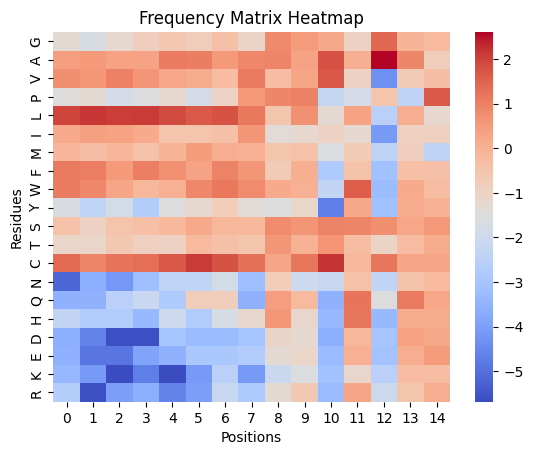

In [ ]:
# @title Show the final matrix as heatmap
sns.heatmap(final_matrix.T[:-1], cmap='coolwarm', fmt='.2f', annot=False, yticklabels=alphabet[:-1])

# Add labels and title
plt.title('Frequency Matrix Heatmap')
plt.xlabel('Positions')
plt.ylabel('Residues')

# Show the plot
plt.show()

### BENCHMARK TEST

In [ ]:
# @title Prepare the benchmark dataframe
# Specify the column names
col_pos_bench = ['ID', 'Species', 'Kingdom', 'Length', 'Cleavage']
col_neg_bench = ['ID', 'Species', 'Kingdom', 'Length', 'Transmembrane']

# Load the TSV file into a DataFrame
pos_bench = pd.read_csv('pos-bench.tsv', sep='\t', header=None, names=col_pos_bench)
neg_bench = pd.read_csv('neg-bench.tsv', sep='\t', header=None, names=col_neg_bench)

#Create a customize file for the positives
with open('positive.fasta', 'r') as read:
  with open('vonHeijne_pos_test.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = pos_bench.query("ID == @line")
        if not query.empty:
          line = read.readline()
          # The final line will contain: id, class (1 for positive), the first 90 characters
          print(query['ID'].iloc[0]+'\t1\t'+line.rstrip()[:90], file=write)
  write.close
read.close

#Create a customize file for the negatives
with open('negative.fasta', 'r') as read:
  with open('vonHeijne_neg_test.tsv', 'w') as write:
    for line in read:
      if '>' in line:
        line = line[1:].rstrip()
        query = neg_bench.query("ID == @line")
        if not query.empty:
          line = read.readline()
          # The final line will contain: id, class (0 for negative), the first 90 characters
          print(query['ID'].iloc[0]+'\t0\t'+line.rstrip()[:90], file=write)
  write.close
read.close

#Read the new files and concatenate them in a unique dataframe
col_test = ['ID', 'Class', 'Sequence']

pos_test = pd.read_csv('vonHeijne_pos_test.tsv', sep='\t', header=None, names=col_test)
neg_test = pd.read_csv('vonHeijne_neg_test.tsv', sep='\t', header=None, names=col_test)

test_df = pd.concat([pos_test, neg_test], axis=0)

In [ ]:
print(test_df.head())

       ID  Class                                           Sequence
0  O75629      1  MAGLSRGSARALLAALLASTLLALLVSPARGRGGRDHGDWDEASRL...
1  P01579      1  MKYTSYILAFQLCIVLGSLGCYCQDPYVKEAENLKKYFNAGHSDVA...
2  P04062      1  MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...
3  P04844      1  MAPPGSSTVFLLALTIIASTWALTPTHYLTKHDVERLKASLDRPFT...
4  P16150      1  MATLLLLLGVLVVSPDALGSTTAVQTPTSGEPLVSTSEPLSSKMYT...


In [ ]:
print(test_df.tail())

          ID  Class                                           Sequence
1753  Q9HFE6      0  MELEKRIYVGGLSSSIESSDLESRFSRFGSVSNLEIINKSTPVGTI...
1754  P10900      0  MGLPWYRVHTVVLNDPGRLLAVHIMHTALVSGWAGSMALYELAVFD...
1755  P12852      0  MALASKVATRPAVASRRGAVVVRASGESRRAVLGGLLASAVAAVAP...
1756  O20030      0  MTQNNILIRRYIIVGERRFSNYWWAIVIFLGSCGFLATGICSYLGI...
1757  Q02749      0  MHMQLRKRKRVDYSGRNQTSDPPSTTTAAVPSIIVPKKRKVVAQNM...


In [ ]:
# @title Final Test and population of the performance file
# Binary representation of the true (observed) class for each validation example: 0=NO_SP, 1=SP
y_test = test_df['Class'].to_numpy()
#print(y_val)
# SP detection scores assigned to each testing example by means of weight matrix scanning
y_test_scores = []
for index, row in test_df.iterrows():
  y_test_scores.append(score_sequence(final_matrix, row['Sequence'], alphabet))
# classify examples in the testing set using the average threshold obtained during the cross-validation
y_pred_test = [int(t_s >= (av_th/5)) for t_s in y_test_scores]

with open('vonHeijne_bench_res.txt', 'w') as write:
  print('The used threshold is: '+str(av_th/5), file=write)
  cm = confusion_matrix(y_test, y_pred_test)
  TN, FP, FN, TP = cm.ravel()
  print("Confusion Matrix:\n"+str(cm), file=write)

  # Calculate metrics
  accuracy = (TP + TN) / (TP + TN + FP + FN)
  sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0 #recall or true positive rate
  ppv = TP / (TP + FP) if (TP + FP) > 0 else 0 #positive predicted values or precision
  fscore = (2 * ppv * sensitivity) / (sensitivity + ppv)
  mcc = ((TP * TN) - (FP * FN)) / np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)) if (TP + FP) * (TP + FN) * (TN + FP) * (TN + FN) > 0 else 0

  print(f'Accuracy: {accuracy:.3f}\nSensitivity: {sensitivity:.3f}\nPPV: {ppv:.3f}\nF1 Score: {fscore:.3f}\nMCC: {mcc:.3f}\n', file=write)
write.close

<function TextIOWrapper.close()>

## Creation of the final file for the evaluation

In [ ]:
# Add the prediction column to the test dataframe
test_df['Prediction'] = y_pred_test
print(test_df.shape)
print(test_df.head())

(1975, 4)
       ID  Class                                           Sequence  \
0  O75629      1  MAGLSRGSARALLAALLASTLLALLVSPARGRGGRDHGDWDEASRL...   
1  P01579      1  MKYTSYILAFQLCIVLGSLGCYCQDPYVKEAENLKKYFNAGHSDVA...   
2  P04062      1  MEFSSPSREECPKPLSRVSIMAGSLTGLLLLQAVSWASGARPCIPK...   
3  P04844      1  MAPPGSSTVFLLALTIIASTWALTPTHYLTKHDVERLKASLDRPFT...   
4  P16150      1  MATLLLLLGVLVVSPDALGSTTAVQTPTSGEPLVSTSEPLSSKMYT...   

   Prediction  
0           1  
1           0  
2           1  
3           1  
4           1  


In [ ]:
# Merge the original pos and bench file to have all the metadata in one file
bench = pd.concat([pos_bench, neg_bench], axis=0)
print(bench.shape)
print(bench.head())
print(bench.tail())

(1975, 6)
       ID                       Species        Kingdom  Length  Cleavage  \
0  P0C8G7          Pomacea canaliculata        Metazoa     286      30.0   
1  O59896       Pycnoporus cinnabarinus          Fungi     518      21.0   
2  Q6UX39                  Homo sapiens        Metazoa     209      16.0   
3  Q6Z232  Oryza sativa subsp. japonica  Viridiplantae     146      42.0   
4  O75462                  Homo sapiens        Metazoa     422      37.0   

  Transmembrane  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
          ID                                            Species  \
1753  Q9LSB9                               Arabidopsis thaliana   
1754  Q9CQE1                                       Mus musculus   
1755  Q8L7F7                               Arabidopsis thaliana   
1756  Q7RYW7  Neurospora crassa (strain ATCC 24698 / 74-OR23...   
1757  Q9P000                                       Homo sapiens   

            Kingdom  L

In [ ]:
# Finally merge the original and the test set by the ID colum to have all the information in one dataframe
final_df = pd.merge(bench, test_df, on='ID', how='outer')
print(final_df.shape)
print(final_df.head())

(1975, 9)
           ID                       Species        Kingdom  Length  Cleavage  \
0  A0A023W145         Ethmostigmus rubripes        Metazoa      88      24.0   
1  A0A0B5KU17    Penicillium brevicompactum          Fungi    2190       NaN   
2  A0A0F7YZQ7               Conus victoriae        Metazoa     100      24.0   
3  A0A0G2K047             Rattus norvegicus        Metazoa     683       NaN   
4  A0A0N7KIY3  Oryza sativa subsp. japonica  Viridiplantae     352       NaN   

  Transmembrane  Class                                           Sequence  \
0           NaN      1  MASQVVLSFALVVVLAVFVGQVDSCPSDCKCDYRSSQCRPANDDVH...   
1         False      0  MNFHKGQPKEDLRVLFGPQCPDITDSITHIRDAISKDPTGLGFLTN...   
2           NaN      1  MAPSQKALLVLVLSMLLTASDSWARRIDCKVFVFAPICRGVAAKRG...   
3         False      0  MKPSWLQCRKVTGAGTLGAPLPGSPSVRGAGVARRALVAGFGGRGC...   
4         False      0  MEHHHLLLQLSPPPPPPPLPAAHLMMSPSFFDAGVFADVGGDWMED...   

   Prediction  
0           1  
1           0 

In [ ]:
# Convert the dataframe in a TSV
final_df.to_csv('vonHeijne_final.tsv', sep='\t', index=False)